# Basic MNIST with Deep Neural Network

Trained using simple 2 hidden layer with 100 neurons each

### Structure of model

1. Fully connected layers

5. RelU

1. Fully connected layers

5. RelU

1. Fully connected layers

2. Output

### Time took to train model

5m 20s for 100 epochs

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import transforms
import os
from torchinfo import summary

In [2]:
class n_net(nn.Module):
    def __init__(self):
        super(n_net,self).__init__()
        self.n1 = nn.Linear(784,100)
        self.relu = nn.ReLU()
        self.n2 = nn.Linear(100,100)
        self.n3 = nn.Linear(100,10)
    def forward(self,x):
        x1 = self.n1(x)
        x2 = self.relu(x1)
        x3 = self.n2(x2)
        x4 = self.relu(x3)
        x5 = self.n3(x4)
        return x5

In [3]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [4]:
DOWNLOAD_ROOT = os.path.join(os.pardir,"MNIST_data")

dataset_1 = datasets.MNIST(root=DOWNLOAD_ROOT,train=True,transform=transforms.ToTensor(),download=True)
dataset_2 = datasets.MNIST(root=DOWNLOAD_ROOT,train=False,transform=transforms.ToTensor(),download=True)

In [5]:
BATCH_SIZE = 128
loader_1 = DataLoader(dataset_1, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
loader_2 = DataLoader(dataset_2, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)

In [6]:
LOAD = True
LEARNING_RATE = 0.01
SEED = 7777
torch.manual_seed(SEED)
if device == 'cuda':
    torch.cuda.manual_seed_all(SEED)
model = n_net()
model.zero_grad()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE)
TOTAL_BATCH = len(loader_1)
EPOCHS = 100
loss_list = []
accuracy_list = []
epoch = 0

In [7]:
summary(model,input_size=(BATCH_SIZE,784))

Layer (type:depth-idx)                   Output Shape              Param #
n_net                                    --                        --
├─Linear: 1-1                            [128, 100]                78,500
├─ReLU: 1-2                              [128, 100]                --
├─Linear: 1-3                            [128, 100]                10,100
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
Total mult-adds (M): 11.47
Input size (MB): 0.40
Forward/backward pass size (MB): 0.22
Params size (MB): 0.36
Estimated Total Size (MB): 0.97

In [7]:
PATH = os.path.join("Saves","pretrained_model.pt")
SAVE_INTERVAL = 5
if LOAD:
    check = torch.load(PATH)
    model.load_state_dict(check["model"])
    epoch = check["epoch"]
    accuracy_list = check["accuracy list"]
    loss_list = check["loss list"]
    optimizer.load_state_dict(check["optimizer"])

In [8]:
while epoch < EPOCHS:
    cost = 0
    for image, label in loader_1:
        image = image.reshape(BATCH_SIZE,784)
        optimizer.zero_grad()
        predicted = model.forward(image)
        loss = loss_function(predicted,label)
        loss.backward()
        optimizer.step()
        cost+=loss
    with torch.no_grad():
        total = 0
        correct = 0
        for image, label in loader_2:
            image = image.reshape(BATCH_SIZE,784)
            out = model(image)
            _,predict = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predict==label).sum()
    average_cost = cost/TOTAL_BATCH
    accuracy = 100*correct/total
    loss_list.append(average_cost.detach().numpy())
    accuracy_list.append(accuracy)
    epoch+=1
    print("epoch : {} | loss : {:.6f}" .format(epoch, average_cost))
    print("Accuracy : {:.2f}".format(accuracy))
    print("---------------------")
    if epoch%5 ==0:
        torch.save({"epoch":epoch,"loss list":loss_list,"accuracy list":accuracy_list,"model":model.state_dict(),"optimizer":optimizer.state_dict()},PATH)


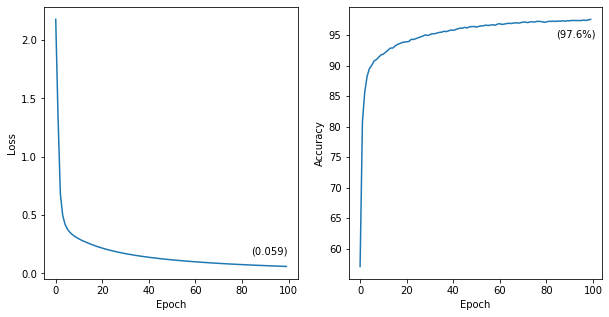

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.text(EPOCHS-1-15,loss_list[-1]+0.1,'({:.3f})'.format(loss_list[-1]))
plt.plot(np.arange(0,EPOCHS),loss_list)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.text(EPOCHS-1-15,accuracy_list[-1]-3,'({:.1f}%)'.format(accuracy_list[-1]))
plt.plot(np.arange(0,EPOCHS), accuracy_list)
plt.savefig('graph.png',facecolor = 'w')
plt.show()


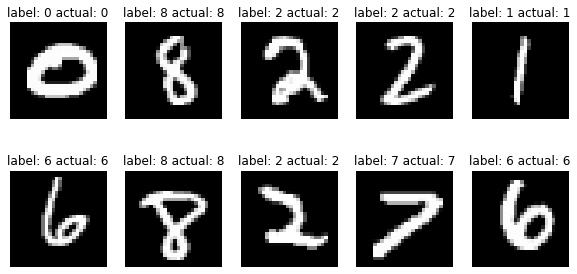

In [12]:
figure = plt.figure(figsize=(10, 5))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_2), size=(1,)).item()
    img, label = dataset_2[sample_idx]
    image = img.reshape(1,784)
    figure.add_subplot(rows, cols, i)
    out = model(image)
    _,predict = torch.max(out.data, 1)
    plt.title("label: {} actual: {}".format(label,predict.item()))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.savefig('output.png',facecolor = 'w')
plt.show()